In [1]:
%matplotlib inline
import math
import os
from itertools import count, groupby
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.distributions import Bernoulli, Normal
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from pytorch_lightning import LightningModule, Trainer

In [2]:
class MnistBetaVAE(LightningModule):
    def __init__(self, beta=1):
        super().__init__()
        self.beta = beta
        self.z_dim = 20
        self.encoder = nn.Sequential(nn.Linear(784, 400),
                                     nn.ReLU(),
                                     nn.Dropout(0.9),
                                     nn.Linear(400, 100),
                                     nn.ReLU(),
                                     nn.Dropout(0.9))
        self.z_loc = nn.Linear(100, 20)
        self.z_scale = nn.Linear(100, 20)
        self.decoder = nn.Sequential(nn.Linear(20, 100),
                                     nn.ReLU(),
                                     nn.Dropout(0.9),
                                     nn.Linear(100, 400),
                                     nn.ReLU(),
                                     nn.Dropout(0.9))
        self.x_loc = nn.Linear(400, 784)
        self.x_scale = nn.Linear(400, 784)
        
    def prepare_data(self):
        # Downloads if necessary
        MNIST(os.getcwd(), train=True, download=True)
        
    def train_dataloader(self):
        # No download, get mnist from disk
        data = MNIST(os.getcwd(), transform=ToTensor())
        return DataLoader(data, batch_size=128)
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)
    
    def encode(self, x):
        h = self.encoder(x)
        return self.z_loc(h), self.z_scale(h)
    
    def reparameterize(self, mu, scale):
        std = 1e-6 + F.softplus(scale)
        eps = torch.randn_like(std)
        return mu + std*eps
    
    def decode(self, z):
        h = self.decoder(z)
        return self.x_loc(h), self.x_scale(h)

    def loss(self, x, x_mu, x_scale, z_mu, z_scale):
        x_std = 1e-6 + F.softplus(x_scale)
        z_std = 1e-6 + F.softplus(z_scale)
        
        norm = -0.5 * math.log(2.0*np.pi) - torch.log(1e-8 + x_std)
        logp = (x - x_mu).pow(2).mul(-1) / x_std.pow(2).mul(2.0) + norm
        logp = logp.sum(1).mean()
        kld = z_mu.pow(2) + z_std.pow(2) - torch.log(1e-8 + z_std.pow(2)) - 1.0
        kld = kld.sum(1).mul(0.5).mean()
        elbo = logp - self.beta*kld
        return -elbo

    def forward(self, x):
        z_mu, z_scale = self.encode(x)
        z = self.reparameterize(z_mu, z_scale)
        x_mu, x_scale = self.decode(z)
        return z, z_mu, z_scale, x, x_mu, x_scale
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.shape[0], -1)
        z, z_mu, z_scale, x, x_mu, x_scale = self.forward(x)
        loss = self.loss(x, x_mu, x_scale, z_mu, z_scale)
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}

In [3]:
@torch.no_grad()
def get_digit_samples():
    by_digit = itemgetter(1)

    mnist = MNIST(os.getcwd(), transform=ToTensor())
    mnist = sorted(mnist, key=by_digit)
    mnist = groupby(mnist, key=by_digit)

    samples = []
    for digit, grp in mnist:
        x, y = next(grp)
        samples.append(x.view(-1))

    return torch.stack(samples)


@torch.no_grad()
def sweep_variable_across_samples(vae, samples, i, sweep):
    """Sweeps a single latent variable
    
    Arguments
    ---------
    vae : torch.Module
        A VAE module; must have a decode method
    samples : n-by-z array-like
        Contains n samples of z latent variables
    i : int < z
        The latent variable to sweep
    sweep : array
        The values to use in sweeping z
    """
    # XXX dumb, unvectorized version
    recons = []
    for sample in samples:
        recons.append([])
        for val in sweep:
            sample[i] = val
            # Use just means as image
            img, _ = vae.decode(sample)
            recons[-1].append(img.detach().numpy())
    return np.array(recons)


@torch.no_grad()
def plot_sweep_grid(origs, recons, sweepvals):
    idx = count(1)
    fig = plt.figure(figsize=(15, 13))
    fig.subplots_adjust(hspace=0, wspace=0)
    for i in range(10):
        plt.subplot(10, 11, next(idx))
        plt.imshow(origs[i].reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.title('Orig')
        for j in range(10):
            plt.subplot(10, 11, next(idx))
            plt.imshow(recons[i][j].reshape(28, 28))
            plt.xticks([])
            plt.yticks([])
            if i == 0:
                plt.title(f'{sweepvals[j]:.2f}')
    plt.show()
    
@torch.no_grad()
def plot_all_sweeps(model):
    digits = get_digit_samples()
    digit_encodings, *_ = model(digits)
    sweep_range = torch.linspace(-4, 4, steps=10)
    
    return digit_encodings, sweep_range
#     for i in range(20):
    for i in range(1):
        print(f'Sweeping reconstructions over latent variable no. {i}')
        recons_by_var = sweep_variable_across_samples(model,
                                                      digit_encodings.clone(),
                                                      i,
                                                      sweep_range)
        plot_sweep_grid(digits.detach().numpy(), recons_by_var, sweep_range)
    return digit_encodings, sweep_range

@torch.no_grad()
def zeroth_mu_sigma(enc, model):
    m, s = model.decode(enc)
    s = F.softplus(s)
    
    m0, s0 = m[0], s[0]
    
    plt.subplot(221)
    plt.imshow(m0.reshape(28, 28), norm=None, cmap='gray', vmin=0.0, vmax=1.0)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(222)
    plt.imshow(s0.reshape(28, 28), norm=None, cmap='gray', vmin=0.0, vmax=1.0)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(223)
    plt.imshow(m0.reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(224)
    plt.imshow(s0.reshape(28, 28))
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    return m, s

# Beta=1

In [4]:
%%time
model = MnistBetaVAE(beta=1)
trainer = Trainer(max_epochs=100, gradient_clip_val=1.0)
trainer.fit(model)


CPU times: user 7h 33min 47s, sys: 6min 5s, total: 7h 39min 52s
Wall time: 42min 37s


1

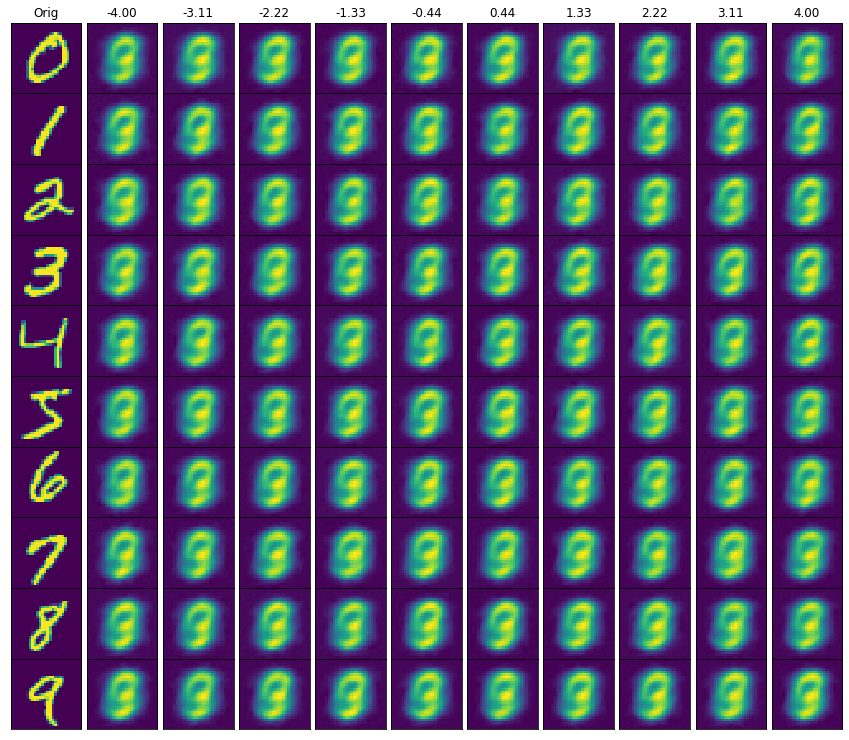

In [5]:
with torch.no_grad():
    digits = get_digit_samples()
    enc, *_ = model(digits)
    swp = torch.linspace(-4, 4, steps=10)
    recons = sweep_variable_across_samples(model, enc.clone(), 0, swp)
    plot_sweep_grid(digits.detach().numpy(), recons, swp)

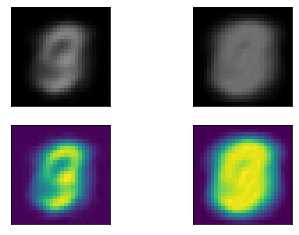

m tensor(-0.0110) tensor(0.5592) tensor(0.1285)
s tensor(0.0019) tensor(0.4535) tensor(0.1992)


In [6]:
with torch.no_grad():
    m, s = zeroth_mu_sigma(enc, model)
    print('m', m.min(), m.max(), m.mean())
    print('s', s.min(), s.max(), s.mean())

In [7]:
with torch.no_grad():
    for r1, r2 in zip(recons, recons[1:]):
        print((r1 == r2).all(), np.allclose(r1, r2))

False False
False False
False False
False False
False False
False False
False False
False False
False False


# Beta=10

In [8]:
%%time
model_b = MnistBetaVAE(beta=10)
trainer = Trainer(max_epochs=100, gradient_clip_val=1.0)
trainer.fit(model_b)


CPU times: user 7h 23min 15s, sys: 5min 41s, total: 7h 28min 57s
Wall time: 41min 35s


1

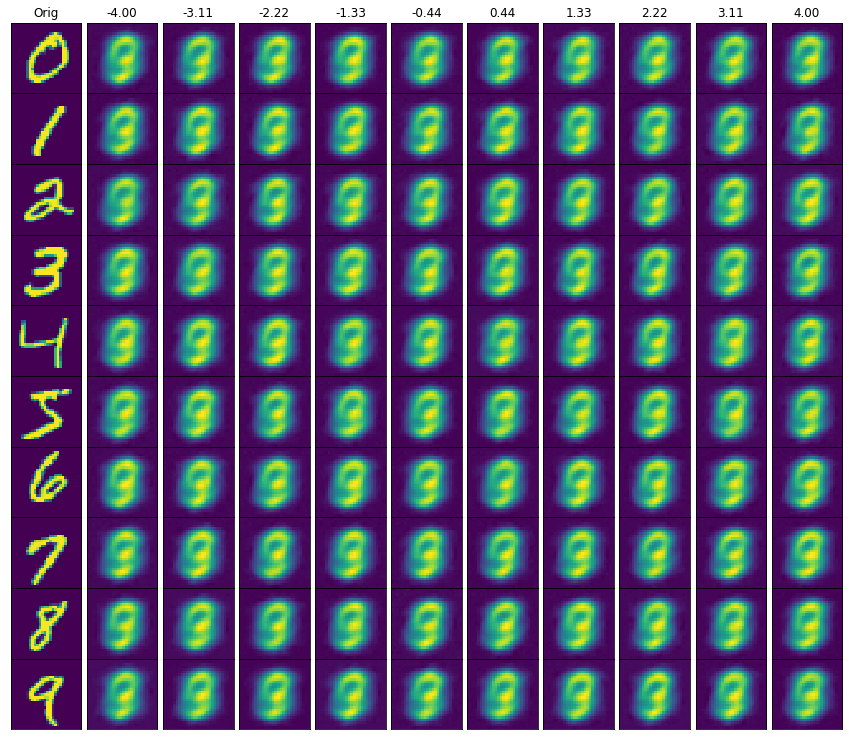

In [9]:
with torch.no_grad():
    digits = get_digit_samples()
    enc, *_ = model_b(digits)
    swp = torch.linspace(-4, 4, steps=10)
    recons = sweep_variable_across_samples(model_b, enc.clone(), 0, swp)
    plot_sweep_grid(digits.detach().numpy(), recons, swp)

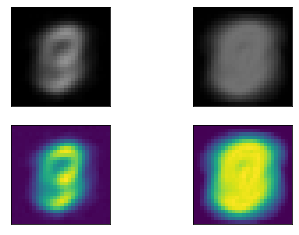

m tensor(-0.0135) tensor(0.5695) tensor(0.1284)
s tensor(0.0008) tensor(0.4561) tensor(0.2023)


In [10]:
with torch.no_grad():
    m, s = zeroth_mu_sigma(enc, model_b)
    print('m', m.min(), m.max(), m.mean())
    print('s', s.min(), s.max(), s.mean())

In [11]:
with torch.no_grad():
    for r1, r2 in zip(recons, recons[1:]):
        print((r1 == r2).all(), np.allclose(r1, r2))

False False
False False
False False
False False
False False
False False
False False
False False
False False


# Beta=0.1

In [12]:
%%time
model_c = MnistBetaVAE(beta=0.1)
trainer = Trainer(max_epochs=100, gradient_clip_val=1.0)
trainer.fit(model_c)


CPU times: user 7h 41min 10s, sys: 6min 38s, total: 7h 47min 49s
Wall time: 43min 27s


1

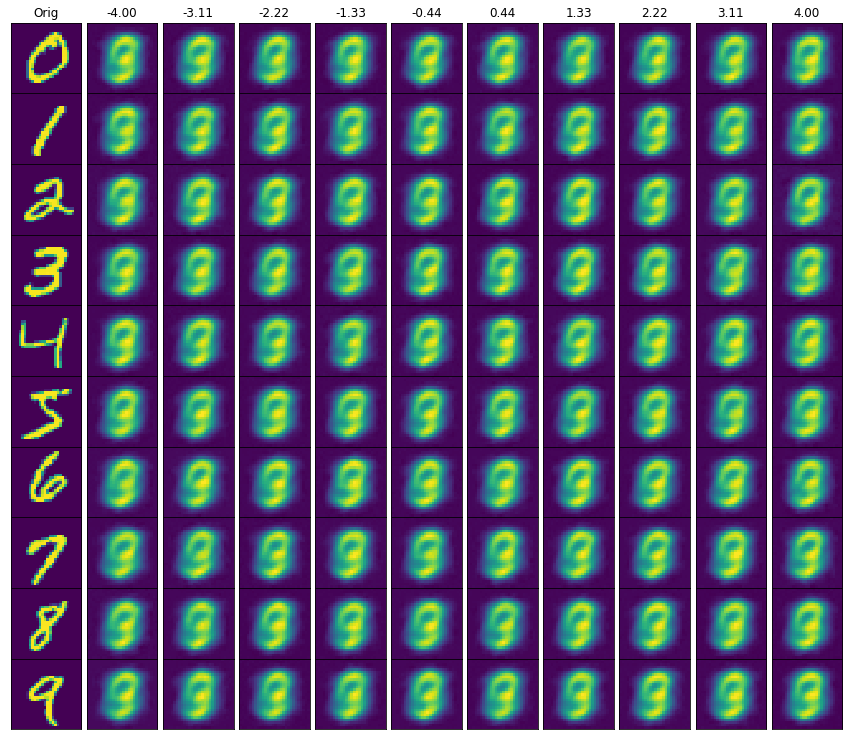

In [13]:
with torch.no_grad():
    digits = get_digit_samples()
    enc, *_ = model_c(digits)
    swp = torch.linspace(-4, 4, steps=10)
    recons = sweep_variable_across_samples(model_c, enc.clone(), 0, swp)
    plot_sweep_grid(digits.detach().numpy(), recons, swp)

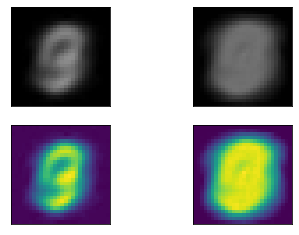

m tensor(-0.0099) tensor(0.5564) tensor(0.1293)
s tensor(0.0012) tensor(0.4555) tensor(0.2040)


In [14]:
with torch.no_grad():
    m, s = zeroth_mu_sigma(enc, model_c)
    print('m', m.min(), m.max(), m.mean())
    print('s', s.min(), s.max(), s.mean())

In [15]:
with torch.no_grad():
    for r1, r2 in zip(recons, recons[1:]):
        print((r1 == r2).all(), np.allclose(r1, r2))

False False
False False
False False
False False
False False
False False
False False
False False
False False
